# Problem Set 2 : Extra problems
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 30-Sep-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the corresponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Holmin, Sebastian**
- Personnummer: **970602-3679**
  <br/>
  (civic registration number)

## Problem 5 (extra): Good-data, bad-data
### Task (a): 3 extra points; Task (b): 1 extra point

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set("talk") # for plot formatting
from scipy.optimize import minimize

Let's start by defining some data that we will fit with a straight line.  The following data is measured velocities and distances for a set of galaxies. We will assume that there is a constant standard deviation of $\sigma = 200$ km/sec on the $y$ values and no error on $x$.

In [2]:
# Data from student lab observations; 
# x = Galaxy distances in MPc
# y = Galaxy velocity in km/sec
x = np.array([10.1 ,45.2, 19.7, 31.2, 31.9, 44.0,
       14.9, 35.1,  39.9  ])
y = np.array([1507.9, 2937.5,  930.4, 2037.1, 2131.1,
       2795.6, 1061.8, 2464.8, 
       1971.1])

### Task (a)

The question that we will be asking is: 
> What value would you infer for the Hubble constant, i.e. the slope of the velocity versus distance relation, given this data?

We will make the prior assumption that the data can be fitted with a straight line. But we note that we are actually not interested in the offset of the straight line, but just its slope.

We will try three different approaches:
1. Maximum likelihood estimate
1. Full Bayesian analysis
1. Full Bayesian analysis incorporating a fully Bayesian approach to good-data-bad-data

As a subsequent task, we will also explore how the posterior belief from this analysis can feed into a second data analysis.

#### Statistical model
Here we are given data with simple error bars (constant $\sigma$), which implies that the probability for any *single* data point is a normal distribution about the true value. That is,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \sigma),
$$

with $y_M(x) = mx + b$.
Or, in other words,

$$
p(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\sigma^2}\right)
$$

where $\sigma$ is the (known) measurement error indicated by the error bars.

#### Step 1: Maximum likelihood estimate

In [23]:
# Insert code here
#
sigma = 200

def neg_log_likelihood(theta,x,y):
    return -np.sum(-1/2*(np.log(2*np.pi*sigma**2)+((y-(theta[0]+theta[1]*x))**2)/(sigma**2))) #

minimize(neg_log_likelihood,[0,0],args=(x,y)).x

array([506.28716416,  48.82611411])

#### Step 2: Bayesian analysis
For the Bayesian analysis we would recommend a Gaussian prior (mean=0, standard deviation=200) for the intercept, and a symmetric prior
$$
p(m|I) \propto \frac{1}{(1+m^2)^{3/2}}
$$
for the slope (the latter was used also in the fitting straight line example).

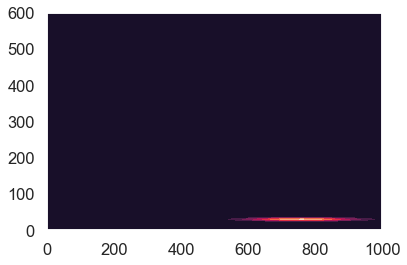

In [45]:
# Did not have time to finish this
#
def log_likelihood(theta,x,y):
    return np.sum(-1/2*(np.log(2*np.pi*sigma**2)+((y-(theta[0]+theta[1]*x))**2)/(sigma**2))) #

def log_prior(theta):
    -np.log((1+theta[1]**2)**(3/2))-(theta[0]**2/(2*(sigma)**2))

def log_posterior(theta,x,y):
    return log_likelihood(theta,x,y) + log_prior(theta)

mesh = 100
m = np.linspace(0,1000,mesh)
b = np.linspace(0,600,mesh)
Av, Bv = np.meshgrid(m, b)
Z = np.zeros((mesh,mesh))

for i in range(mesh):
    for j in range(mesh):
        theta = [b[j],m[i]]
        Z[i,j] = np.exp(log_likelihood(theta,x,y))
        
plt.contourf(Av, Bv, Z)
mode=np.where(Z == np.amax(Z))

#### Step 3: Bayesian Approach to Outliers (good-data/bad-data)

There are several Bayesian approaches to accounting for outliers. They generally involve *modifying the statistical model*. For this data, it is abundantly clear that a simple straight line is not a good fit to our data. So let's propose a more complicated model that has the flexibility to account for outliers where the experimental error bar might have been underestimated. 

Specifically we will assume that there is a chance that the error distribution is represented by a Lorentzian distribution rather than a Gaussian. The peaks of these two distributions are very similar in shape, but the Lorentzian has much heavier tails.

We will use a statistical model in which we allow each individual data point $(x_i,y_i)$ to be described by
a mixture between a Gaussian and a Lorentzian error model:

$$
\begin{array}{ll}
p(\{x_i\}, \{y_i\},\{e_i\}~|~\theta,\{g_i\},\sigma) = & g_i \frac{1}{\sqrt{2\pi e_i^2}}\exp\left[\frac{-\left(y_M(x_i~|~\theta) - y_i\right)^2}{2e_i^2}\right] \\
&+ (1 - g_i) \frac{1}{\sqrt{2}\pi \sigma} \frac{1}{1 + \left[ y_M (x_i~|~\theta) - y_i\right]^2 / (2\sigma^2)}
\end{array}
$$

What we've done is expanded our model with some nuisance parameters: $\{g_i\}$ is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the different error models. 

Our model is much more complicated now: it has one new parameter per data point, but these can be considered nuisance parameters that can be marginalized-out in the end.  You can use a uniform prior $U(0,1)$ for these parameters. Your task is to implement this likelihood and to use, e.g., the [emcee](http://dan.iel.fm/emcee/current/) MCMC package to explore the parameter space.

### Task (b): Error propagation

The Bayesian approach offers a straight-forward approach for dealing with (known) systematic uncertainties; namely by marginalization.

The Hubble constant acts as a galactic ruler as it is used to measure astronomical distances according to $v = H_0 x$. An error in this ruler will therefore correspond to a systematic uncertainty in such measurements.

Suppose that a particular galaxy has a measured recessional velocity $v_\mathrm{measured} = (100 \pm 5) \times 10^3$ km/sec. Also assume that the Hubble constant $H_0$ is known from the analysis performed above in Step 3. Determine the posterior pdf for the distance to the galaxy assuming:
1. A fixed value of $H_0$ corresponding to the posterior mean of the previous analysis.
1. Using the full, sampled posterior pdf for $H_0$ from the same analysis.

In this analysis we will set the intercept $m=0$ so that $v_\mathrm{theory} = H_0 x$.

In [32]:
vm=100000
sig_vm=5000

We assume that we can write
$$
v_\mathrm{measured} = v_\mathrm{theory} + \delta v_\mathrm{exp},
$$
where $v_\mathrm{theory}$ is the recessional velocity according to our model, and $\delta v_\mathrm{exp}$ represents the noise component of the measurement. We that $\delta v_\mathrm{exp}$ can be described by a Gaussian pdf with mean 0 and standard deviation $\sigma_v = 5 \times 10^3$ km/sec. Note that we have also assumed that our model is perfect, i.e. $\delta v_\mathrm{theory}$ is negligible.

In the following, we also assume that the error in the measurement in $v$ is uncorrelated with the uncertainty in $H_0$.

Through application of Bayes' rule we can readily evaluate the posterior pdf $p(x|D,I)$ for the distance $x$ to the galaxy.

#### Case 1: Fixed $H_0$

\begin{align}
p(x | D,I) & \propto p(D | x, I) p(x|I) \\
& = \frac{1}{\sqrt{2\pi}\sigma_v} \exp \left( - \frac{(v_\mathrm{measured} - v_\mathrm{theory})^2}{2\sigma_v^2} \right) p(x|I)\\
&= \left\{ \begin{array}{ll} \frac{1}{\sqrt{2\pi}\sigma_v} \exp \left( - \frac{(v_\mathrm{measured} - H_0 x)^2}{2\sigma_v^2} \right) & \text{with }x \in [x_\mathrm{min},x_\mathrm{max}] \\
0 & \text{otherwise},
\end{array} \right.
\end{align}


where $p(x|I)$ is the prior for the distance which we have assumed to be uniform, i.e. $p(x|I) \propto 1$ in some (possibly large) region $[x_\mathrm{min},x_\mathrm{max}]$.

#### Case 2: Using the inferred pdf for $H_0$

Here we use marginalization to obtain the desired posterior pdf $p(x|D,I)$ from the joint distribution of $p(x,H_0|D,I)$
$$
p(x|D,I) = \int_{-\infty}^\infty dH_0 p(x,H_0|D,I).
$$

Using Bayes' rule, the product rule, and the fact that $H_0$ is independent of $x$ we find that
$$
p(x|D,I) \propto p(x|I) \int dH_0 p(H_0|I) p(D|x,H_0,I),
$$
which means that we have expressed the quantity that we want (the posterior for $x$) in terms of quantities that we know.

The pdf $p(H_0 | I)$ is known via its $N$ samples $\{H_{i}\}$ generated by the MCMC sampler.

This means that we can approximate 
$$
p(x |D,I) = \int dH_0 p(H_0|I) p(D|x,H_0,I) \approx \frac{1}{N} \sum_{i=1}^N p(D | x, H_i, I)
$$
where we have used $p(x|I) \propto 1$.

## Problem 6 (extra): Auto-correlation time of the MCMC sampler
### (2 extra points)

A challenge when doing MCMC sampling is that the collected samples can be *correlated*. This can be tested by computing the *autocorrelation function* and extacting the correlation time.

We can define the autocorrelation function $\rho(h)$ from the list of samples $X$. Say that $X_t$ is sample $t$ and $X_{t+h}$ is a shifted version of $X_t$ with $h$ being called the *lag*
$$
\rho(h) = \frac{\sum_\mathrm{overlap} \left[ (X_t - \bar{X}) (X_{t+h} - \bar{X})\right]}
{\sqrt{ \sum_\mathrm{overlap} (X_t - \bar{X})^2 } \sqrt{ \sum_\mathrm{overlap} (X_{t+h} - \bar{X})^2 }}
$$
The summation is carried out over the subset of samples that overlap.

* Try to understand what the autocorrelation time measures and why it is large (small) when the samples are correlated (not correlated).

* It is often observed that $\rho(h)$ is roughly exponential so that we can define an autocorrelation time $\tau$ according to
$$
\rho(h) \sim \exp(-h/\tau).
$$

#### Task
Repeat the MCMC sampling of a Lorentzian pdf using the random walk Metropolis algorithm from Problem 4.

Extract both the autocorrelation time and the acceptance ratio $\tau$ for some different choices of the proposal width; e.g. 0.1, 0.5, 1.0, 2.0. What is a good choice for sampling this distribution?